In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)

Using PyTorch version: 2.0.1+cpu


In [6]:
batch_size = 32

slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = './data'

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#print(train_dataset)
#rint(train_dataset)


In [7]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


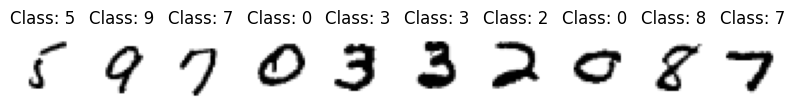

In [8]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

In [9]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP()
print(model)

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                               # count number of correct ones

In [13]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        
        # Do a forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)
    
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

In [14]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

Training epoch: 1
Average loss: 0.430089, accuracy: 88.72%
Training epoch: 2
Average loss: 0.246909, accuracy: 93.10%
Training epoch: 3
Average loss: 0.207596, accuracy: 94.23%
Training epoch: 4
Average loss: 0.182883, accuracy: 94.86%
Training epoch: 5
Average loss: 0.166010, accuracy: 95.32%
Training epoch: 6
Average loss: 0.154031, accuracy: 95.59%
Training epoch: 7
Average loss: 0.144532, accuracy: 95.79%
Training epoch: 8
Average loss: 0.138177, accuracy: 95.97%
Training epoch: 9
Average loss: 0.131890, accuracy: 96.23%
Training epoch: 10
Average loss: 0.126313, accuracy: 96.31%
CPU times: total: 5min 23s
Wall time: 2min 56s


In [15]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
        
            # Do a forward pass
            output = model(data)
        
            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()
        
            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [16]:
test(test_loader, model, criterion)

Testset accuracy: 95.3%, average loss: 0.152004
